#  Loading and Preprocessing the MNIST Dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

## Load MNIST dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Shape of the Dataset

In [3]:
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


## Display a Sample Image

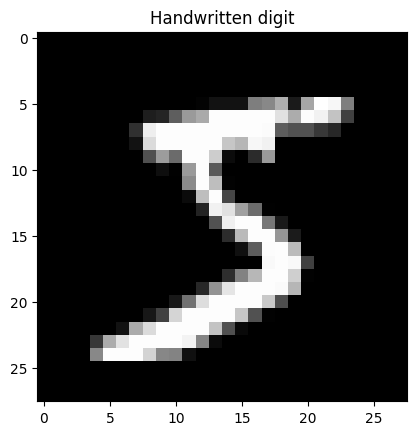

In [4]:
plt.imshow(x_train[0], cmap='gray')
plt.title('Handwritten digit')
plt.show()

## Displaying 10 Images from the training set

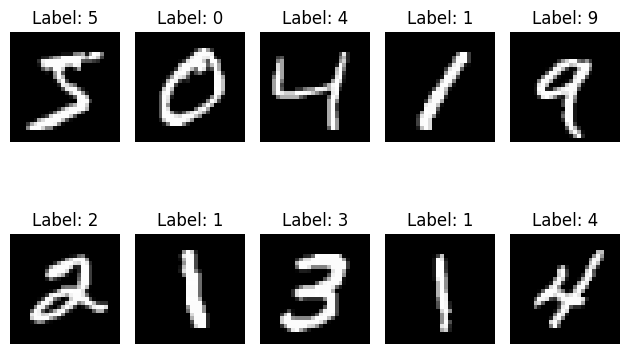

In [5]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Normalize the Images

In [8]:
# (convert pixel values from [0,255] to [0,1])
x_train = x_train / 255.0
x_test = x_test / 255.0

## Creating Segmentation Masks

In [9]:
# Convert images to binary masks
y_train = np.where(x_train > 0.5, 1, 0)  # If pixel > 0.5, make it 1 (digit), else 0 (background)
y_test = np.where(x_test > 0.5, 1, 0)

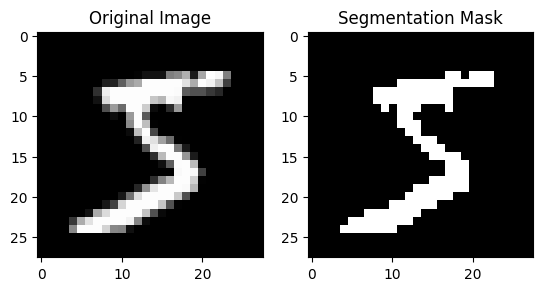

In [10]:
# Display example image and mask
fig, axes = plt.subplots(1, 2)
axes[0].imshow(x_train[0], cmap="gray")
axes[0].set_title("Original Image")
axes[1].imshow(y_train[0], cmap="gray")
axes[1].set_title("Segmentation Mask")
plt.show()

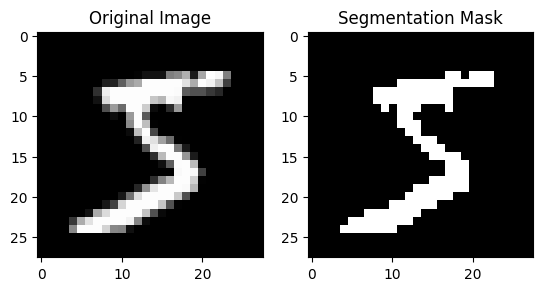

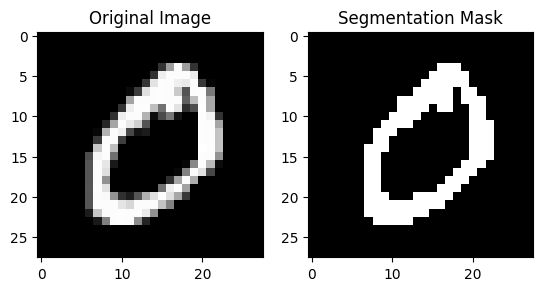

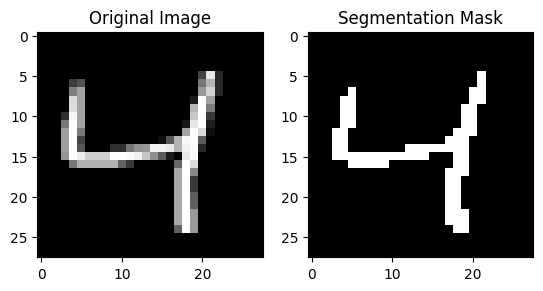

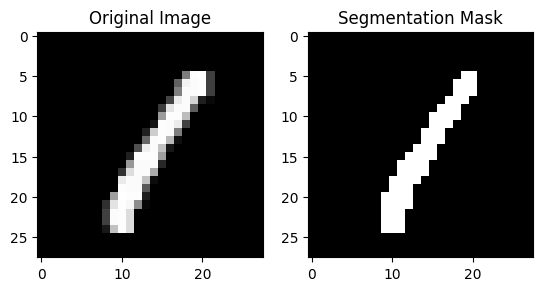

In [11]:
for i in range(4):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(x_train[i], cmap="gray")
    axes[0].set_title("Original Image")
    axes[1].imshow(y_train[i], cmap="gray")
    axes[1].set_title("Segmentation Mask")
    plt.show()

## Reshape for U-Net

In [12]:
# Add channel dimension (for grayscale images, channels = 1)
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

x_test = np.expand_dims(x_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [13]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 28, 28, 1)


# Building the U-Net Model Architecture

1️⃣ Contracting Path (Downsampling) - Like zooming out to capture an overview.
* The image size decreases (downsampling).
* Important features are extracted.

2️⃣ Expanding Path (Upsampling) – Like zooming in to restore details.
* The image size increases (upsampling).
* The segmentation mask is reconstructed.

3️⃣ Skip Connections – Like keeping a backup while zooming.

* Helps the network recover lost details by copying features from earlier layers.

In [18]:
def unet_model(input_shape=(28, 28, 1)):
    inputs = layers.Input(shape=input_shape)

    # constracting path
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # skip connections (bottleneck)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Expanding Path
    u1 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    # Output layer (Segmentation Map)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

# creating unet model
model = unet_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 28, 28, 32)     │          9,248 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 14, 14, 32)     │              0 │ conv2d_23[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 14, 14, 64)     │         36,928 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 7, 7, 64)       │              0 │ conv2d_25[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 7, 7, 128)      │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 7, 7, 128)      │        147,584 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 14, 14, 64)     │         73,792 │ conv2d_27[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 14, 14, 128)    │              0 │ conv2d_transpose_4[0]… │
│ (Concatenate)             │                        │                │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 14, 14, 64)     │         73,792 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 14, 14, 64)     │         36,928 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 28, 28, 32)     │         18,464 │ conv2d_29[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 28, 28, 64)     │              0 │ conv2d_transpose_5[0]… │
│ (Concatenate)             │                        │                │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 28, 28, 32)     │         18,464 │ concatenate_5[0][0]    │
├──────────────────────

 Total params: 517,153 (1.97 MB)

 Trainable params: 517,153 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

## Visualizing U-Net Architecture

In [19]:
from tensorflow.keras.utils import plot_model

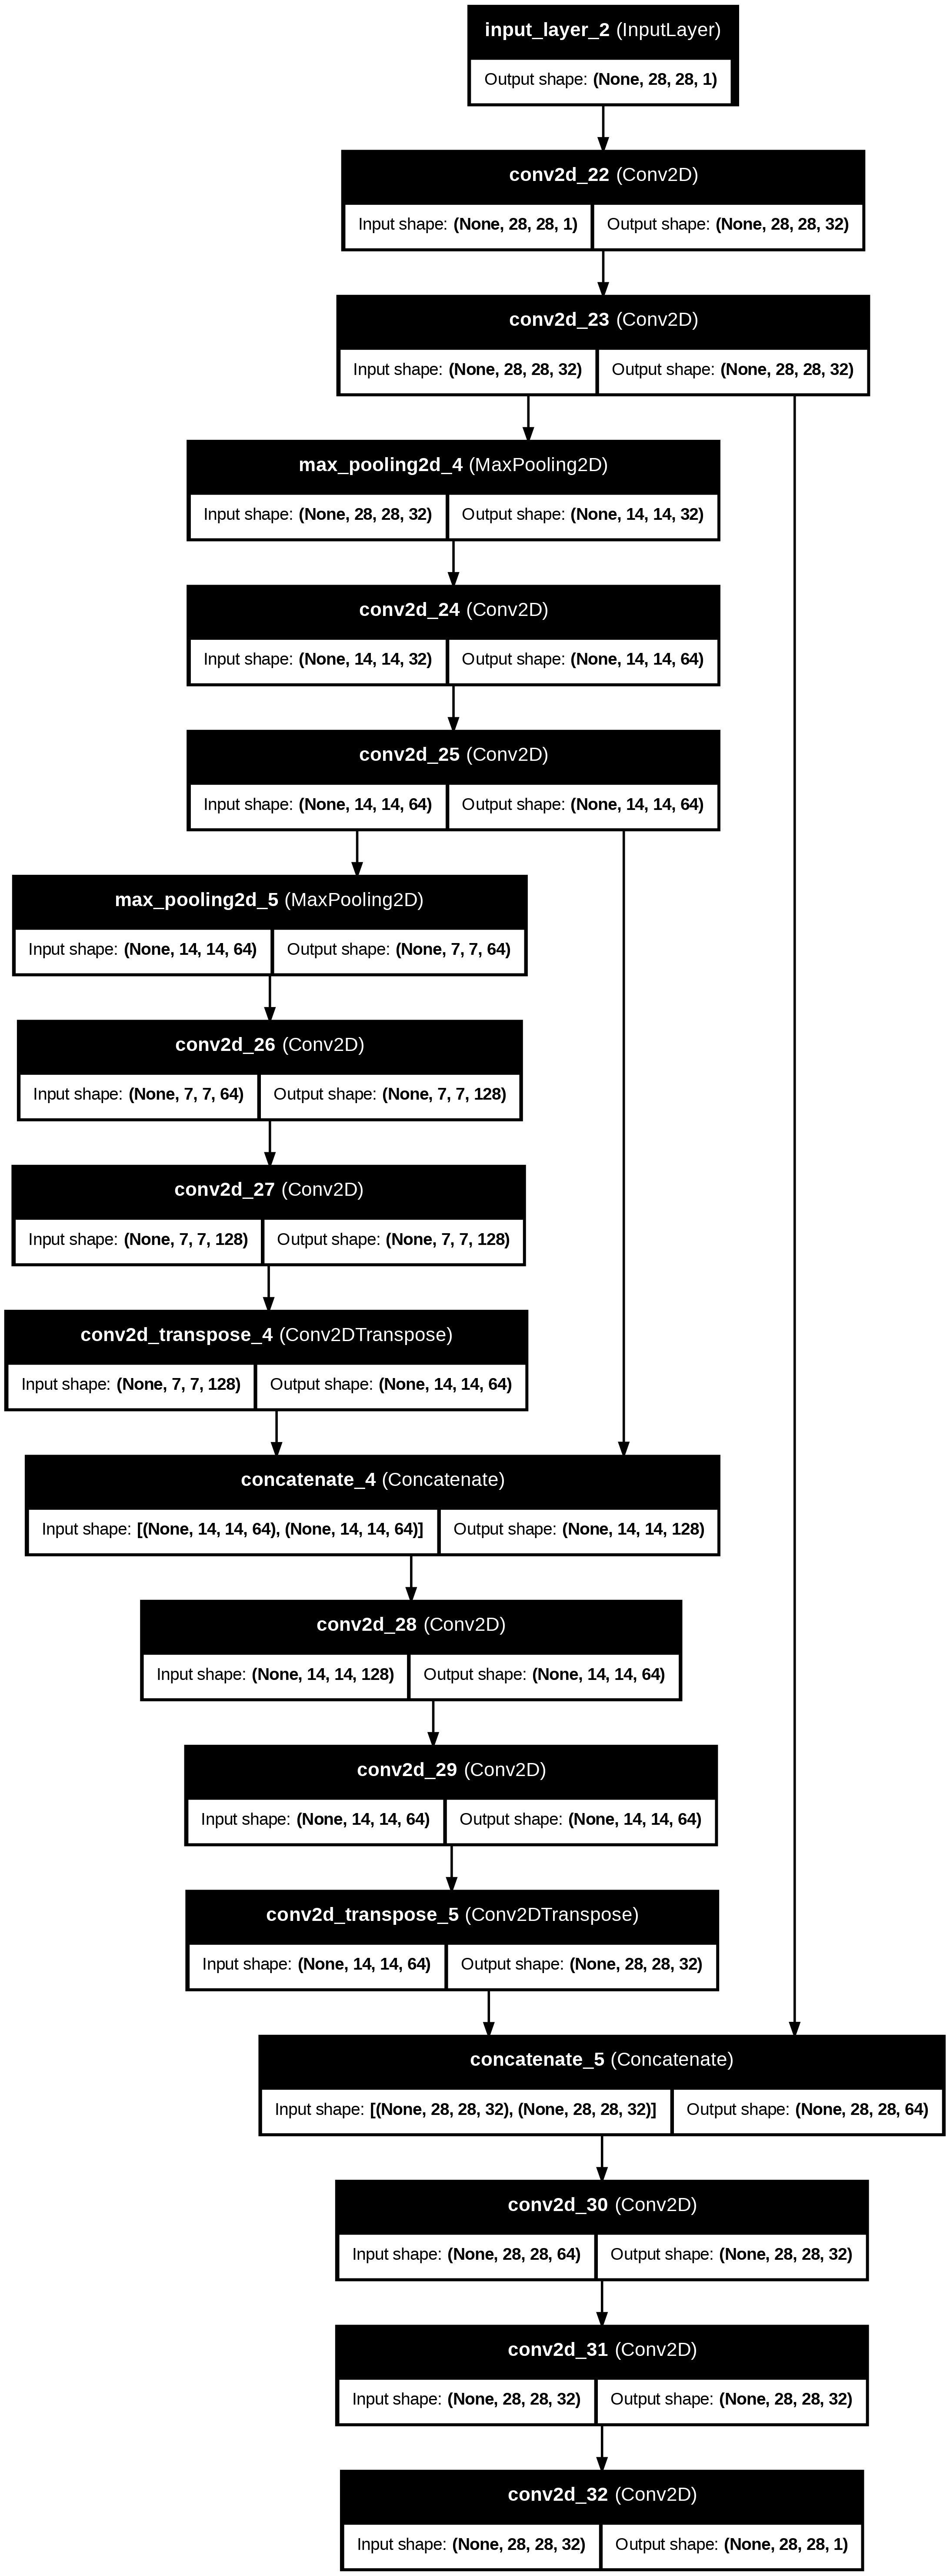

In [20]:
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

# Training the Model

In [22]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

## Compile Model

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Model Fitting

In [26]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val))

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 501s 297ms/step - accuracy: 0.9993 - loss: 0.0016 - val_accuracy: 0.9984 - val_loss: 0.0058
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 483s 286ms/step - accuracy: 0.9993 - loss: 0.0016 - val_accuracy: 0.9995 - val_loss: 0.0011
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 494s 293ms/step - accuracy: 0.9993 - loss: 0.0015 - val_accuracy: 0.9991 - val_loss: 0.0017
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 503s 294ms/step - accuracy: 0.9994 - loss: 0.0014 - val_accuracy: 0.9987 - val_loss: 0.0024
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 503s 294ms/step - accuracy: 0.9993 - loss: 0.0016 - val_accuracy: 0.9996 - val_loss: 9.5818e-04
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 496s 291ms/step - accuracy: 0.9995 - loss: 0.0013 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 494s 293ms/step - accuracy: 0.9995 - loss: 0.0013 - val_accuracy: 0.9995 - val_loss: 0.0011
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 497s 290ms/step 

## Model Evaluation

In [27]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.9996 - loss: 9.6458e-04
Test Loss: 0.0009945508791133761, Test Accuracy: 0.9995938539505005


# Visualization

## Choosing random image

In [29]:
import random
random_index = random.randint(0, len(x_test) - 1)
random_image = x_test[random_index]
random_mask = y_test[random_index]

## Prediction for segmentation mask

In [37]:
predicted_mask = model.predict(np.expand_dims(random_image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


## Predicting random_image, random_mask, and predicted_mask

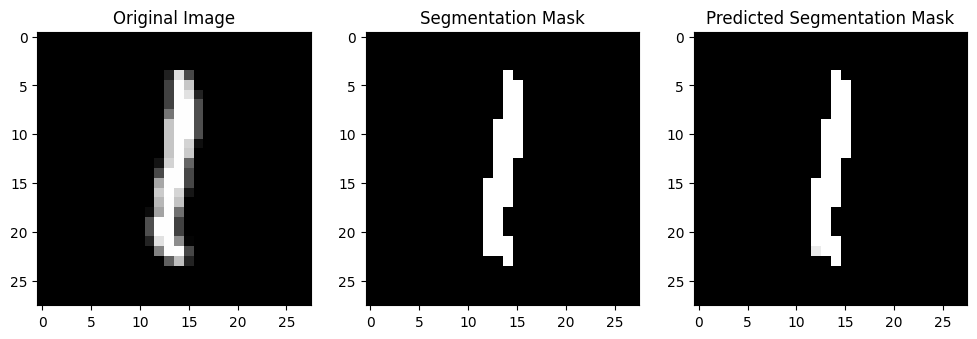

In [38]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(random_image.squeeze(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(random_mask.squeeze(), cmap='gray')
plt.title('Segmentation Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title('Predicted Segmentation Mask')

plt.show()